In [97]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow.keras.backend as K 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from math import sqrt

### 1. read file

In [2]:
data = pd.read_csv("preprocessing_csv/lstm_24group_1619.csv")
team = list(data.T_ID.unique())

data = pd.concat([data, pd.get_dummies(data.T_ID)], axis = 1)
# data.drop(["T_ID"], axis = 1, inplace = True)

In [3]:
train_data = data[data["IDX"] != 6]
test_data = data[data["IDX"] > 4]

In [11]:
year_lst = [2016,2017,2018,2019]

###  2. shift window 생성

In [7]:
def shift_window_pct(df, team, window_size):
    res = pd.DataFrame([])

    for t in team:
        tmp2 = df[df["T_ID"]==t]
        for s in range(1, window_size+1):
            tmp2.loc[:,'shift_{}'.format(s)] = tmp2.loc[:,'PCT'].shift(s)

        res = pd.concat([res, tmp2], axis=0)

    return res

In [8]:
tr_lst = []
te_lst = []
w_size = 1

for i in year_lst:
    t1 = train_data[train_data["YEAR"]==i]
    t2 = test_data[test_data["YEAR"]==i]

    train_df = shift_window_pct(t1, team, w_size)
    test_df = shift_window_pct(t2, team, w_size)
    
    tr_lst.append(train_df)
    te_lst.append(test_df)
    
    del train_df
    del test_df

# train_df = pd.DataFrame([])

# for y in [2016,2017,2018,2019]:
    
#     for t in team:
#         tmp_train = train_data[train_data["T_ID"]==t]
#         for s in range(1, 2):
#             tmp_train.loc[:,'shift_{}'.format(s)] = tmp_train.loc[:,'PCT'].shift(s)

#         train_df = pd.concat([train_df, tmp_train], axis=0)

# test_df = pd.DataFrame([])
# for t in team:
#     tmp_test = test_data[test_data["T_ID"]==t]
#     for s in range(1, 2):
#         tmp_test.loc[:,'shift_{}'.format(s)] = tmp_test.loc[:,'PCT'].shift(s)
    
#     test_df = pd.concat([test_df, tmp_test], axis=0)


c:\users\julia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\julia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
X_tr_lst = []
y_tr_lst = []

for i in range(len(tr_lst)):
    X_train = tr_lst[i].dropna().drop(['PCT','T_ID'], axis=1).reset_index(drop=True)
    y_train = tr_lst[i].dropna()[['PCT']].reset_index(drop=True)
    
    X_tr_lst.append(X_train)
    y_tr_lst.append(y_train)
    
    del X_train
    del y_train
    

In [14]:
X_te_lst = []
y_te_lst = []

for i in range(len(te_lst)):
    X_test = te_lst[i].dropna().drop(['PCT','T_ID'], axis=1).reset_index(drop=True)
    y_test = te_lst[i].dropna()[['PCT']].reset_index(drop=True)
    
    X_te_lst.append(X_test)
    y_te_lst.append(y_test)
    
    del X_test
    del y_test


### 3. ndarray 변환

In [21]:
X_tr_v_lst = []
y_tr_v_lst = []
for i in range(len(X_tr_lst)):
    
    X_train_v = X_tr_lst[i].values
    y_train_v = y_tr_lst[i].values
    
    X_tr_v_lst.append(X_train_v)
    y_tr_v_lst.append(y_train_v)

In [22]:
X_te_v_lst = []
y_te_v_lst = []
for i in range(len(X_te_lst)):
    
    X_test_v = X_te_lst[i].values
    y_test_v = y_te_lst[i].values
    
    X_te_v_lst.append(X_test_v)
    y_te_v_lst.append(y_test_v)

# X_test_v = X_test.values
# y_test_v = y_test.values

In [23]:
print(X_train_v.shape)
print(X_train_v)
print(y_train_v.shape)
print(y_train_v)

(40, 90)
[[2.01900000e+03 2.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.41666667e-01]
 [2.01900000e+03 3.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.00000000e-01]
 [2.01900000e+03 4.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 6.95652174e-01]
 ...
 [2.01900000e+03 3.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.33333333e-01]
 [2.01900000e+03 4.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.41666667e-01]
 [2.01900000e+03 5.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 4.16666667e-01]]
(40, 1)
[[0.5       ]
 [0.69565217]
 [0.5       ]
 [0.54166667]
 [0.58333333]
 [0.33333333]
 [0.47826087]
 [0.54166667]
 [0.41666667]
 [0.5       ]
 [0.65217391]
 [0.52173913]
 [0.54166667]
 [0.54166667]
 [0.70833333]
 [0.56521739]
 [0.70833333]
 [0.5       ]
 [0.5       ]
 [0.66666667]
 [0.45833333]
 [0.29166667]
 [0.25      ]
 [0.375     ]
 [0.70833333]
 [0.66666667]
 [0.70833333]
 [0.6

### 4. 최종 train 의 X 만들기
* 3차원 데이터여야하며 각각의 차원은 (size, timestep, feature)

In [24]:
X_train_v.shape

(40, 90)

In [167]:
X_tr_t_lst = []

for i in range(len(X_tr_v_lst)):
    X_train_t = X_tr_v_lst[i].reshape(X_tr_v_lst[i].shape[0],1,90)
    
    X_tr_t_lst.append(X_train_t)

In [168]:
X_te_t_lst = []

for i in range(len(X_te_v_lst)):
    X_test_t = X_te_v_lst[i].reshape(X_te_v_lst[i].shape[0],1,90)
    
    X_te_t_lst.append(X_test_t)

# X_test_t = X_test_v.reshape(X_test_v.shape[0],90,1)

In [169]:
X_tr_t_lst[0].shape, X_te_t_lst[0].shape, 

((40, 1, 90), (10, 1, 90))

### 5. LSTM 모델 생성

#### 2016

In [182]:
K.clear_session() 

model = Sequential()

model.add(LSTM(90,input_shape = (1,90))) # (timestep, feature)
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90)                65160     
_________________________________________________________________
dense (Dense)                (None, 1)                 91        
Total params: 65,251
Trainable params: 65,251
Non-trainable params: 0
_________________________________________________________________


In [183]:
early_stop = EarlyStopping(monitor='loss', mode = 'min', patience=3, verbose=1)


hist1 = model.fit(X_tr_t_lst[0], y_tr_v_lst[0], epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Train on 40 samples
Epoch 1/100
40/40 [==============================] - 2s 46ms/sample - loss: 0.0592 - mae: 0.1816
Epoch 2/100
40/40 [==============================] - 0s 3ms/sample - loss: 0.0111 - mae: 0.0870
Epoch 3/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.0112 - mae: 0.0817
Epoch 4/100
40/40 [==============================] - 0s 3ms/sample - loss: 0.0122 - mae: 0.0910
Epoch 5/100
40/40 [==============================] - 0s 2ms/sample - loss: 0.0113 - mae: 0.0865
Epoch 00005: early stopping


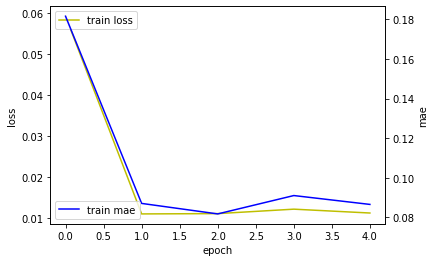

In [184]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label='train loss')

acc_ax.plot(hist1.history['mae'], 'b', label='train mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mae')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

#### 2017

In [115]:
K.clear_session() 

model17 = Sequential()

model17.add(LSTM(20,input_shape = (90,1))) # (timestep, feature)
model17.add(Dense(1)) # output = 1
model17.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                8880      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 8,901
Trainable params: 8,901
Non-trainable params: 0
_________________________________________________________________


In [116]:
early_stop = EarlyStopping(monitor='loss', mode = 'min', patience=3, verbose=1)


hist17 = model17.fit(X_tr_t_lst[1], y_tr_v_lst[1], epochs=100,
          batch_size=10, verbose=1, callbacks=[early_stop])

Train on 40 samples
Epoch 1/100
40/40 [==============================] - 2s 43ms/sample - loss: 0.1869 - mae: 0.4063
Epoch 2/100
40/40 [==============================] - 0s 3ms/sample - loss: 0.1179 - mae: 0.3147
Epoch 3/100
40/40 [==============================] - 0s 3ms/sample - loss: 0.0641 - mae: 0.2256
Epoch 4/100
40/40 [==============================] - 0s 3ms/sample - loss: 0.0303 - mae: 0.1389
Epoch 5/100
40/40 [==============================] - 0s 4ms/sample - loss: 0.0190 - mae: 0.1094
Epoch 6/100
40/40 [==============================] - 0s 4ms/sample - loss: 0.0246 - mae: 0.1245
Epoch 7/100
40/40 [==============================] - 0s 4ms/sample - loss: 0.0280 - mae: 0.1366
Epoch 8/100
40/40 [==============================] - 0s 3ms/sample - loss: 0.0235 - mae: 0.1228
Epoch 00008: early stopping


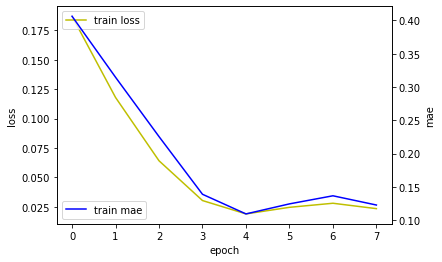

In [117]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist17.history['loss'], 'y', label='train loss')

acc_ax.plot(hist17.history['mae'], 'b', label='train mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mae')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 성능확인

##### 같은 값이 나오는 이유: 오버피팅, 데이터 부족

In [185]:
y_te_v_lst[0]

array([[0.60869565],
       [0.56521739],
       [0.29166667],
       [0.375     ],
       [0.66666667],
       [0.5       ],
       [0.45833333],
       [0.5       ],
       [0.5       ],
       [0.45833333]])

In [189]:
y_pred = model.predict(X_te_t_lst[0], batch_size = 1)

In [190]:
pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_te_v_lst[0].reshape(-1)})

,y_pred,y
0,0.495327,0.608696
1,0.495327,0.565217
2,0.495327,0.291667
3,0.495327,0.375000
4,0.495327,0.666667
5,0.495327,0.500000
6,0.495327,0.458333
7,0.495327,0.500000
8,0.495327,0.500000
9,0.495327,0.458333


In [191]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.13188475685150614

#### 2017

In [120]:
y_te_v_lst[1]

array([[0.43478261],
       [0.5       ],
       [0.5       ],
       [0.34782609],
       [0.58333333],
       [0.43478261],
       [0.625     ],
       [0.66666667],
       [0.39130435],
       [0.5       ]])

In [121]:
y_pred17 = model17.predict(X_te_t_lst[1])

In [136]:
tttmp = pd.DataFrame({"y_pred":y_pred17.reshape(-1), 
              "y":y_te_v_lst[1].reshape(-1)})

tttmp

,y_pred,y
0,0.514450,0.434783
1,0.550415,0.500000
2,0.525153,0.500000
3,0.563608,0.347826
4,0.564259,0.583333
5,0.526895,0.434783
6,0.547708,0.625000
7,0.549069,0.666667
8,0.554891,0.391304
9,0.528689,0.500000


In [139]:
tttmp

,y_pred,y,A
0,0.514450,0.434783,0.5
1,0.550415,0.500000,0.5
2,0.525153,0.500000,0.5
3,0.563608,0.347826,0.5
4,0.564259,0.583333,0.5
5,0.526895,0.434783,0.5
6,0.547708,0.625000,0.5
7,0.549069,0.666667,0.5
8,0.554891,0.391304,0.5
9,0.528689,0.500000,0.5


In [123]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.13167720025663052

In [146]:
rms = sqrt(mean_squared_error(y_test_v, np.array(tttmp.A).reshape(10,1)))
rms

0.1316220123204481